# Exploring Airbnb listings and pricing in the Greater Montréal Area

In this notebook, we will be answering the following Questions about Airbnb market in Montréal, QC, Canada.

* What is the breakdown of listings by neighbourhood?
* What is the share of the different listing type in Montreal?
* What is the average price listing per room type per neighbourhood?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from pathlib import Path
import requests 
from IPython.display import display
%matplotlib inline

### download Airbnb dataset from source.
Download the datasets need from source if they are not already there. 

In [2]:
# download data to project folder listings.csv.gz
# This will create a subfolder where this notebook is installed and download the file.

data_src = 'listings.csv.gz'
url= 'http://data.insideairbnb.com/canada/qc/montreal/2020-03-17/data/listings.csv.gz'

def download_url(url, save_path, chunk_size=256):
    """
    Check if file already exists, if not use url to download it.
    Args:
        url(str): URL of the zipped file.
        save_path(str): Path where the file should be saved
        chunk_size(int): Chunk size to iterate over from the streamed request.
    """
    # check if file exists at path or not
    if not Path(save_path).exists():
        r = requests.get(url, stream=True)
        with open(save_path, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=chunk_size):
                fd.write(chunk)

# Download from url if file doesn't exist.
download_url(url, data_src)

    
# Display all columns to have an understanding of the feature vectors provided. 
pd.options.display.max_columns = None

### Cleaning up the dataframe 
Here we will:
* Remove columns that are deemed unnecessary to answer the above mentioned questions.
* Drop all the columns that are empty or have a high percentage of empty values(more than 80%).
* Fill or drop values that doesn't make sense (0 accomodations, 0% host response etc). 
* Make sure that the datatypes are in the right type, else update these to make use of the data.

We can do the folowing as we are answering the questions: 
* Check categorical data and if they need to be imputed/dummies be created.



In [3]:
# Read the compressed csv file to a pandas dataframe. This is in a separate cell as to run it once.
df = pd.read_csv(data_src, compression='gzip', error_bad_lines=False)

# drop empty columns inplace in the same cell and get the names of the dropped columns
num_features_before = set(df.columns)
df.dropna(how='all',axis=1,inplace=True)
num_features_after = set(df.columns)

print(f'Dropped columns are: {(num_features_before - num_features_after)}')

Dropped columns are: {'medium_url', 'thumbnail_url', 'license', 'xl_picture_url', 'neighbourhood_group_cleansed'}


/Users/faisalbarazi/projects/airbnb_mtl_prices/airbnb_mtl_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Explore the dataset a bit
df.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2078,https://www.airbnb.com/rooms/2078,20200317175912,2020-03-18,Central comfy close to Metro Laurie,Centrally located in trendy Le Plateau. Join...,Centrally located clean comfy furnished room ...,Centrally located in trendy Le Plateau. Join...,none,Although my place is centrally located in Le P...,I always inform my guests the places/attractio...,I am 6-8 mins. walk to Metro Laurie and bus ro...,You will have full access in the apartment. I...,I am always available to help and give informa...,No house rules but I expect my guests to follo...,https://a0.muscache.com/im/pictures/88170231/0...,2277,https://www.airbnb.com/users/show/2277,Nelia,2008-08-19,"Montreal, Québec, Canada","Honest, quiet and adhere to the golden rules a...",within an hour,100%,0%,f,https://a0.muscache.com/im/users/2277/profile_...,https://a0.muscache.com/im/users/2277/profile_...,Le Plateau,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Montreal, QC, Canada",Le Plateau-Mont-Royal,Le Plateau-Mont-Royal,Montreal,QC,H2J 3E9,Montreal,"Montreal, Canada",CA,Canada,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,""Pets live on this prop...",NaN,$39.00,$190.00,NaN,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,2 weeks ago,t,0,0,0,76,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,"{Quebec,"" CA""}",t,f,flexible,f,f,1,0,1,0,2.36
1,2843,https://www.airbnb.com/rooms/2843,20200317175912,2020-03-18,Fabulous downtown/airport room,Come stay in this trendy area of downtown Mont...,"Private individual room in the downtown area, ...",Come stay in this trendy area of downtown Mont...,none,This area of St Henri is actually downtown Mon...,From this room you can walk to downtown Montre...,There is a major metro/subway stop called Lion...,"The guests can use the kitchen anytime, fully ...",I meet guests when they arrive show them the h...,No smoking and no pets Airport bus stops acros...,https://a0.muscache.com/im/pictures/397204dc-4...,2319,https://www.airbnb.com/users/show/2319,Gail,2008-08-19,"Montreal, Québec, Canada",Manage a network of downtown rooms and private...,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/7c04e...,https://a0.muscache.com/im/pictures/user/7c04e...,Little Burgundy,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",

In [5]:
# Further clean up the dataframe by droping un-useful data. 
columns_to_drop = [
    'state', 'city', 'neighbourhood', 'street', 'host_picture_url','host_thumbnail_url',
    'host_about', 'host_location','host_url' ,'host_id', 'picture_url','house_rules',
    'access', 'interaction', 'notes', 'neighborhood_overview', 'description', 'space',
    'scrape_id', 'listing_url','id','transit','experiences_offered','summary','host_name',
    'host_neighbourhood', 'smart_location','country_code','country','market','amenities',
    'jurisdiction_names','last_scraped','calendar_updated','availability_30',
    'availability_60', 'availability_90','availability_365','name','zipcode','host_listings_count',
    'host_verifications','require_guest_profile_picture','require_guest_phone_verification'
]
df.drop(columns=columns_to_drop,axis=1, inplace=True,)


In [6]:
df.head(5)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-08-19,within an hour,100%,0%,f,1.0,t,t,Le Plateau-Mont-Royal,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$39.00,$190.00,NaN,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,t,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,t,f,flexible,1,0,1,0,2.36
1,2008-08-19,within an hour,100%,100%,f,6.0,t,t,Le Sud-Ouest,45.48496,-73.58001,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$30.00,$245.00,$650.00,$134.00,$25.00,1,$10.00,1,365,1,1,365,365,1.0,365.0,t,2020-03-18,143,29,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,f,t,f,moderate,6,3,3,0,1.09
2,2009-11-25,within a few hours,90%,74%,t,1.0,t,t,Le Plateau-Mont-Royal,45.54135,-73.57814,f,Loft,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,$175.00,$950.00,"$3,000.00",$200.00,$0.00,2,$20.00,3,1125,3,3,1125,1125,3.0,1125.0,t,2020-03-18,175,30,2011-06-06,2020-03-01,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,strict_14_with_grace_period,1,1,0,0,1.64
3,2010-05-14,within an hour,100%,99%,t,2.0,t,t,Ville-Marie,45.51939,-73.56482,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,$80.00,NaN,NaN,$0.00,$75.00,2,$15.00,2,60,2,2,60,60,2.0,60.0,t,2020-03-18,324,48,2010-06-20,2020-03-08,94.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,moderate,2,2,0,0,2.73
4,2010-05-14,within an hour,100%,99%,t,2.0,t,t,Ville-Marie,45.51929,-73.56493,t,House,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,$145.00,NaN,NaN,$0.00,$120.00,2,$20.00,3,21,3,3,21,21,3.0,21.0,t,2020-03-18,66,21,2012-02-23,2020-02-17,92.0,10.0,9.0,9.0,9.0,10.0,9.0,f,t,f,moderate,2,2,0,0,0.67


**Descirbe the data to check min values, max and quantiles**



**percentage of missing values for each column**

In [7]:
def missing_percentage(df):
    """
    Finds percentage of missing values in dataframe.
    returns a dataframe with these percentages
    """
    
    missing = 1 - df.count()/len(df)
    missing = missing.reset_index()
    missing.rename(columns={'index': 'column', 0: 'missing_perc'},inplace=True)
    missing.sort_values('missing_perc', axis=0, ascending=False, inplace=True)
    return missing.T

missing = missing_percentage(df)
missing

,19,22,21,2,1,23,3,24,47,46,44,43,42,45,41,39,40,56,17,16,15,0,7,6,5,4,20,48,9,8,49,11,50,51,52,53,54,55,10,12,18,30,14,25,26,27,13,29,31,38,32,33,34,35,36,37,28
column,square_feet,monthly_price,weekly_price,host_response_rate,host_response_time,security_deposit,host_acceptance_rate,cleaning_fee,review_scores_value,review_scores_location,review_scores_checkin,review_scores_cleanliness,review_scores_accuracy,review_scores_communication,review_scores_rating,first_review,last_review,reviews_per_month,beds,bedrooms,bathrooms,host_since,host_identity_verified,host_has_profile_pic,host_total_listings_count,host_is_superhost,price,requires_license,latitude,neighbourhood_cleansed,instant_bookable,is_location_exact,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,longitude,property_type,bed_type,maximum_minimum_nights,accommodates,guests_included,extra_people,minimum_nights,room_type,minimum_minimum_nights,minimum_maximum_nights,number_of_reviews_ltm,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,maximum_nights
missing_perc,0.988253,0.903896,0.888283,0.397998,0.397998,0.337778,0.278697,0.238452,0.218973,0.218725,0.218577,0.218279,0.218279,0.21818,0.217437,0.198305,0.198305,0.198305,0.00718676,0.00158604,0.0012391,0.000198255,0.000198255,0.000198255,0.000198255,0.000198255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Since most of the values in square_feet, monthly_price and weekly_price are missing, We can likely drop these safely. As square_feet is likely to play a role in pricing, will keep this for now and drop the other 2.

In [8]:
df.drop(columns=['monthly_price','weekly_price'],inplace=True)

In [9]:
df.head(5)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-08-19,within an hour,100%,0%,f,1.0,t,t,Le Plateau-Mont-Royal,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$39.00,$0.00,$0.00,1,$6.00,2,7,2,2,7,7,2.0,7.0,t,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,t,f,flexible,1,0,1,0,2.36
1,2008-08-19,within an hour,100%,100%,f,6.0,t,t,Le Sud-Ouest,45.48496,-73.58001,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,$30.00,$134.00,$25.00,1,$10.00,1,365,1,1,365,365,1.0,365.0,t,2020-03-18,143,29,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,f,t,f,moderate,6,3,3,0,1.09
2,2009-11-25,within a few hours,90%,74%,t,1.0,t,t,Le Plateau-Mont-Royal,45.54135,-73.57814,f,Loft,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,$175.00,$200.00,$0.00,2,$20.00,3,1125,3,3,1125,1125,3.0,1125.0,t,2020-03-18,175,30,2011-06-06,2020-03-01,98.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,strict_14_with_grace_period,1,1,0,0,1.64
3,2010-05-14,within an hour,100%,99%,t,2.0,t,t,Ville-Marie,45.51939,-73.56482,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,$80.00,$0.00,$75.00,2,$15.00,2,60,2,2,60,60,2.0,60.0,t,2020-03-18,324,48,2010-06-20,2020-03-08,94.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,f,moderate,2,2,0,0,2.73
4,2010-05-14,within an hour,100%,99%,t,2.0,t,t,Ville-Marie,45.51929,-73.56493,t,House,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,$145.00,$0.00,$120.00,2,$20.00,3,21,3,3,21,21,3.0,21.0,t,2020-03-18,66,21,2012-02-23,2020-02-17,92.0,10.0,9.0,9.0,9.0,10.0,9.0,f,t,f,moderate,2,2,0,0,0.67


In [10]:
# Functions to clean the data
def prices_to_float(value):
    if value:
        value = str(value).replace('$','')
        value = value.replace(',','')
        value = float(value)
        return value

def bool_str_to_int(value):
    if value == 'f':
        return int(0)
    else:
        return int(1)

def percentage_to_float(value):
    value = str(value).strip('%')
    return float(value)


def update_dtype(df, clmns_list, func):
    for clmn in clmns_list:
        df[clmn] = df[clmn].apply(func)


In [11]:
# Update prices dtype to float
clmns_prices = ['price','security_deposit','cleaning_fee','guests_included','extra_people']
update_dtype(df, clmns_prices, prices_to_float)

# Update percentage
clmns_percentage = ['host_response_rate', 'host_acceptance_rate']
update_dtype(df, clmns_percentage, percentage_to_float)

# Update boolean string to float
bool_clmns = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified','is_location_exact',
    'requires_license', 'instant_bookable','is_business_travel_ready','has_availability']
update_dtype(df, bool_clmns, bool_str_to_int)
df.head(5)

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2008-08-19,within an hour,100.0,0.0,0,1.0,1,1,Le Plateau-Mont-Royal,45.53069,-73.58588,1,House,Private room,2,1.0,1.0,1.0,Real Bed,NaN,39.0,0.0,0.0,1.0,6.0,2,7,2,2,7,7,2.0,7.0,1,2020-03-18,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,0,1,0,flexible,1,0,1,0,2.36
1,2008-08-19,within an hour,100.0,100.0,0,6.0,1,1,Le Sud-Ouest,45.48496,-73.58001,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,30.0,134.0,25.0,1.0,10.0,1,365,1,1,365,365,1.0,365.0,1,2020-03-18,143,29,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,0,1,0,moderate,6,3,3,0,1.09
2,2009-11-25,within a few hours,90.0,74.0,1,1.0,1,1,Le Plateau-Mont-Royal,45.54135,-73.57814,0,Loft,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,175.0,200.0,0.0,2.0,20.0,3,1125,3,3,1125,1125,3.0,1125.0,1,2020-03-18,175,30,2011-06-06,2020-03-01,98.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,strict_14_with_grace_period,1,1,0,0,1.64
3,2010-05-14,within an hour,100.0,99.0,1,2.0,1,1,Ville-Marie,45.51939,-73.56482,1,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,NaN,80.0,0.0,75.0,2.0,15.0,2,60,2,2,60,60,2.0,60.0,1,2020-03-18,324,48,2010-06-20,2020-03-08,94.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,moderate,2,2,0,0,2.73
4,2010-05-14,within an hour,100.0,99.0,1,2.0,1,1,Ville-Marie,45.51929,-73.56493,1,House,Entire home/apt,5,1.0,2.0,2.0,Real Bed,NaN,145.0,0.0,120.0,2.0,20.0,3,21,3,3,21,21,3.0,21.0,1,2020-03-18,66,21,2012-02-23,2020-02-17,92.0,10.0,9.0,9.0,9.0,10.0,9.0,0,1,0,moderate,2,2,0,0,0.67


**Dataframe description**

Let us look at the max, min,median and quantiles of the quantitative data.

In [12]:
df.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,12146.000000,14553.000000,20176.000000,20172.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20151.000000,20144.000000,20031.000000,237.000000,20176.000000,13361.000000,15365.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.000000,20176.0,20176.000000,20176.000000,15789.000000,15772.000000,15772.000000,15766.000000,15774.000000,15763.000000,15758.000000,20176.000000,20176.000000,20176.0,20176.000000,20176.000000,20176.000000,20176.000000,16175.000000
mean,94.095422,85.601319,0.191862,13.209697,0.995936,0.318497,45.515823,-73.589155,0.838323,3.557891,1.154384,1.417941,1.849683,621.248945,114.639076,300.410224,55.669444,1.835845,11.220410,9.673771,826.305115,8.725218,10.573454,878.866376,881.767793,9.829679,880.549554,1.0,23.592486,9.636598,93.554437,9.609181,9.319237,9.736902,9.716305,9.673920,9.426196,0.000099,0.450238,0.0,6.353985,5.444489,0.781176,0.096501,1.367746
std,17.193358,24.682412,0.393775,79.282379,0.063623,0.465905,0.031458,0.042650,0.368164,2.453214,0.524828,1.050253,1.532448,1621.273258,223.844398,487.498385,57.695440,1.699833,21.175039,88.918571,9989.901386,33.616818,89.351153,9988.342881,9988.208815,67.953060,9988.248330,0.0,46.883489,17.964066,8.946320,0.840489,1.085340,0.761868,0.777932,0.687682,0.922444,0.009956,0.497530,0.0,17.024542,17.002036,2.245622,1.511642,1.774375
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.404540,-73.964380,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.010000
25%,99.000000,83.000000,0.000000,1.000000,1.000000,0.000000,45.497485,-73.602940,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,49.000000,0.000000,25.000000,1.000000,0.000000,1.000000,40.000000,1.000000,1.000000,65.000000,89.000000,1.000000,89.000000,1.0,1.000000,0.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.180000
50%,100.000000,98.000000,0.000000,1.000000,1.000000,0.000000,45.518940,-73.579455,1.000000,3.000000,1.000000,1.000000,1.000000,200.000000,79.000000,200.000000,50.000000,1.000000,0.000000,2.000000,1125.000000,2.000000,2.000000,1125.000000,1125.000000,2.000000,1125.000000,1.0,5.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.640000
75%,100.000000,100.000000,0.000000,4.000000,1.000000,1.000000,45.533740,-73.565898,1.000000,4.000000,1.000000,2.000000,2.000000,900.000000,120.000000,450.000000,75.000000,2.000000,20.000000,4.000000,1125.000000,4.000000,5.000000,1125.000000,1125.000000,4.200000,1125.000000,1.0,23.000000,11.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,1.000000,0.0,3.000000,2.000000,

Notice that the minimum host response is 0% which raises a redflag for some entries. Having 0 bathrooms as well does.

Further the _max price_ is very high for a one night (more than 13000$), so is the max cleaning fee and deposit.

We can explore these further when looking at the prices



## Listing by neighbourhood in Montréal
Although the data needs further cleaning for non-sensical data, we can get rough estimate of listing per neighbourhood and listing room type stats. 

In [13]:
# Check for null values in the neighbourhood_cleansed.count() ignores nan values, 
# so if division is 1.0 there is no missing values
df['neighbourhood_cleansed'].count()/len(df['neighbourhood_cleansed'])

1.0

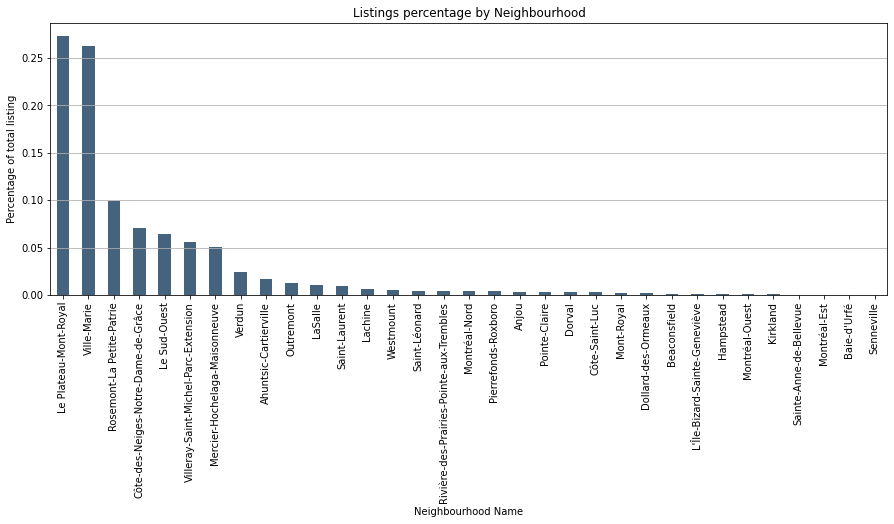

In [14]:
# Get listings by neighbourhood
cat_nhood = df['neighbourhood_cleansed'].value_counts()
cat_nhood_perc = cat_nhood/df.shape[0]

cat_nhood_plot = cat_nhood_perc.plot(kind="bar",figsize=(15,5),
                                            color='#46637D',
                                           title ="Listings percentage by Neighbourhood");
cat_nhood_plot.set_xlabel('Neighbourhood Name')
cat_nhood_plot.set_ylabel('Percentage of total listing')
cat_nhood_plot.grid('off', axis='y' )

We can see from the daigram above that 2 neighbourhoods account for more than 50% of the listings in Montréal. These 2 are central areas that are well serviced by public transportation.

## Listings by Room Type

In [15]:
# Check for missing data. If answer is 1.0, there is no missing data.
df['room_type'].count()/len(df['room_type'])


1.0

In [16]:
room_type = df['room_type'].value_counts()
room_type

Entire home/apt    14311
Private room        5604
Shared room          201
Hotel room            60
Name: room_type, dtype: int64

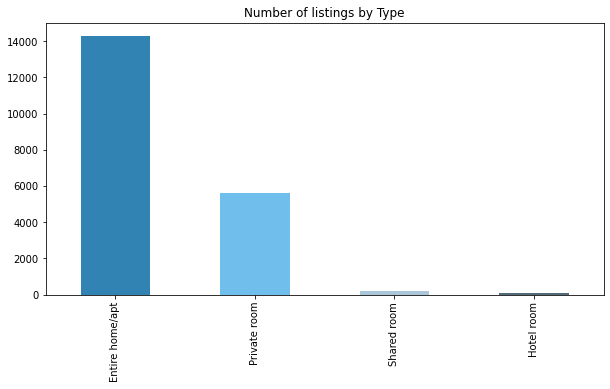

In [17]:
room_type_plot = room_type.plot(kind="bar",figsize=(10,5),
                                            color=['#3083B3','#70BEEB','#A9C7D9','#526B7A'], title ="Number of listings by Type"
)

Text(0, 0.5, 'Room Type')

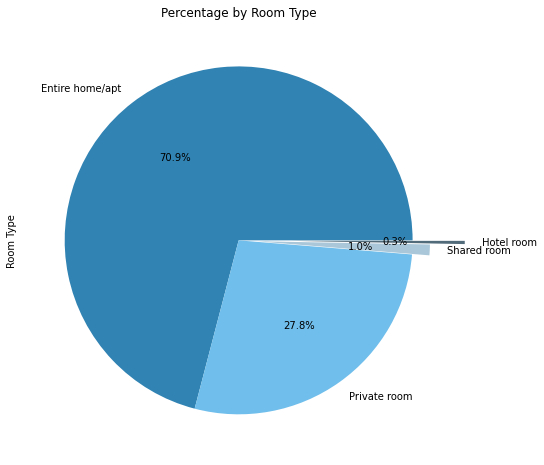

In [18]:
room_type_perc = room_type/df.shape[0]
room_type_pie = room_type_perc.plot.pie(figsize=(8,8),autopct='%1.1f%%',
                                        explode=(0, 0, 0.1,0.3),colors = ['#3083B3','#70BEEB','#A9C7D9','#526B7A'],
                                        title='Percentage by Room Type'
                                       )
room_type_pie.set_ylabel('Room Type')


## Listing By Room Type for the 3 major neighbourhoods

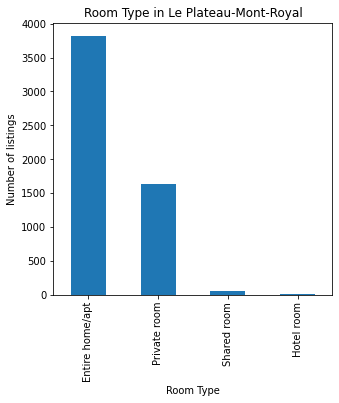

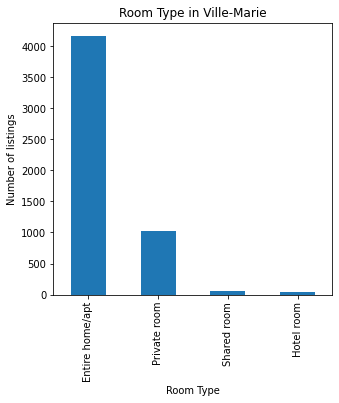

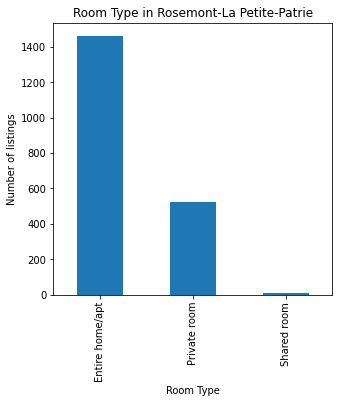

In [19]:
def plot_room_type_nhood(nhood_list):
    """Plots the number of units of each type for the first major neihbourhoods."""
    for nhood in nhood_list:
        df_major_nhood = df[
            df['neighbourhood_cleansed'].isin(
            [nhood]
            ) 
        ]
        x = df_major_nhood['room_type'].value_counts().reset_index()
        x.rename(columns={'index': 'room_type', 'room_type': 'count'}, inplace=True)
        x.set_index('room_type',inplace=True)
        plot = x.plot(kind='bar',legend=None,title=f'Room Type in {nhood}',figsize=(5,5))
        plot.set_xlabel('Room Type')
        plot.set_ylabel('Number of listings')

plot_room_type_nhood(['Le Plateau-Mont-Royal', 'Ville-Marie', 'Rosemont-La Petite-Patrie'])

## What does the prices look like in Montreal for each room type?

In [20]:
#copy over the main dataframe and do some visualization to check some values. 
df_pred = df.copy()
df_pred = df_pred[
    ['host_is_superhost','host_total_listings_count',
    'neighbourhood_cleansed', 
    'room_type', 'accommodates',
    'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
    'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'review_scores_rating', 
    'is_business_travel_ready', 'reviews_per_month',
    'host_response_rate', 'host_acceptance_rate']
]
df_pred.shape

(20176, 18)

**Further cleaning of the data**

As mentioned earlyer, square_feet has a lot of missing values, likely this is what is causing a not so strong correlation with the price. 

Let's remove columns with 0 host acceptance rate and 0 bathrooms. That should clean some of the entries that doesn't make sense.

In [21]:
# out of curiosity, what is 13295$ charged on
df[df['price']== 13295]

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
66,2011-05-29,NaN,NaN,0.0,0,2.0,1,1,Le Plateau-Mont-Royal,45.52023,-73.57075,1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,NaN,13295.0,6647.0,4121.0,1.0,398.0,99,9999,99,99,9999,9999,99.0,9999.0,1,2020-03-18,1,0,2011-08-13,2011-08-13,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,strict_14_with_grace_period,1,0,1,0,0.01


Cleaning fee for '4121' and a security deposit of '6647'. Seems like 'price' in certain cases is showing some weird numbers.
This particular instance is a host since 2011, who is supposedly verified (including an actual ID face match, since jumio is an IDaaS). However they have 0% host acceptance rate. 
We can further clean the dataset by removing everything with an acceptance rate of 0%.


In [22]:
df_pred = df_pred[df_pred['host_acceptance_rate']>0]
df_pred = df_pred[df_pred['bathrooms']>0]
df_pred.shape

(13984, 18)

In [23]:
# Since square_feet is very sparse and has a lot of the missing values we can safely drop it. 
df_pred.drop(columns=['square_feet'],inplace=True)

Let's update the quantitative data by filling the missing values with the mean

In [24]:
def fill_na(df):
    quan_clmns_list = df.select_dtypes('float')
    for clmn in quan_clmns_list:
        df[clmn].fillna(df[clmn].mean(),inplace=True)

In [25]:
fill_na(df_pred)

After filling the NaNs let's look at a correlation matrix to see relations between the different vectors/features and price.

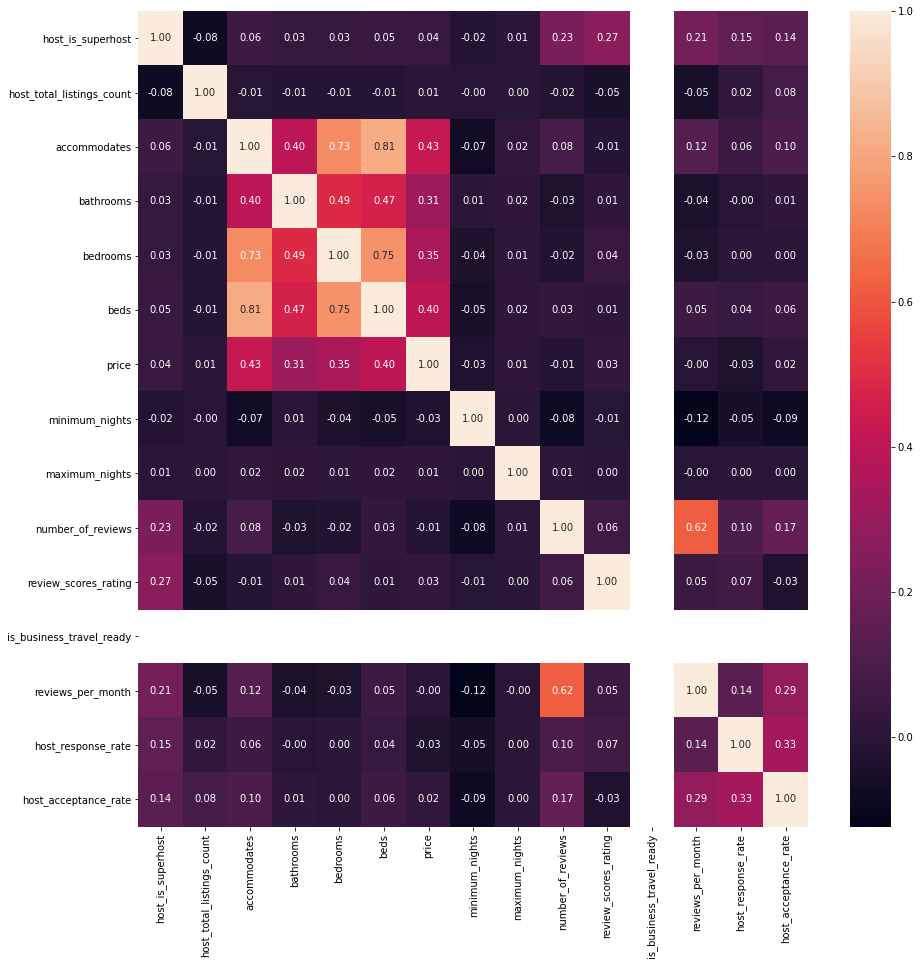

In [26]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df_pred.corr(), annot=True, fmt=".2f", ax=ax);

It is clear that price has to do with number of beds, number of occupants,number of bedrooms which is intuitivel correlated with square meters/feet. We dropped the square feet since most of the data is missing (around 98% of the data). Likely, having that would have given us better prediction.

Let's look at the overall price distribution and then look at the price distribution for the 2 main room types: Entire home and private room.

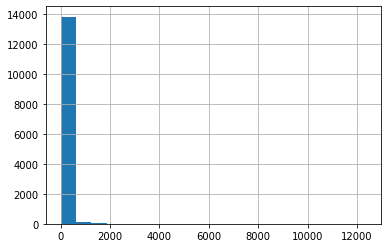

In [27]:
df_pred['price'].hist(bins=20)

From the plot above there seems to be still some outliers/extremes that we want to further clean. 
We can look at the price columns and look at some of the heighst values.

In [28]:
df_pred.sort_values('price',ascending=False).head()

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,is_business_travel_ready,reviews_per_month,host_response_rate,host_acceptance_rate
2851,0,1.0,Rosemont-La Petite-Patrie,Entire home/apt,1,1.0,0.0,3.0,12333.0,2,14,17,87.000000,0,0.630000,33.0,63.0
12378,0,1.0,Mont-Royal,Entire home/apt,6,1.5,3.0,3.0,4199.0,31,365,5,100.000000,0,0.290000,100.0,74.0
13366,0,4.0,Dorval,Entire home/apt,16,6.0,8.0,9.0,3999.0,1,1125,2,100.000000,0,0.260000,60.0,96.0
20036,1,1.0,Le Plateau-Mont-Royal,Entire home/apt,2,2.0,2.0,2.0,3500.0,180,365,0,93.664855,0,1.727244,100.0,100.0
10152,1,13.0,Le Plateau-Mont-Royal,Entire home/apt,16,4.5,12.0,24.0,3500.0,1,1125,8,100.000000,0,0.360000,100.0,92.0


Will consider the 12333.0 an outlier as it is way far of, espicially given that it doesn't even look like a big home since it accomodates only 1 person and has 0 bedrooms. Not sure were the beds are fitted in. 

0.994 of the prices are below 1000


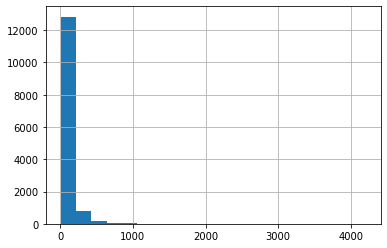

In [43]:
df_pred = df_pred[df_pred['price'] <  5000 ]
price_5000 = df_pred['price']
price_5000.hist(bins=20)
price_1000 = df_pred[df_pred['price'] <  1000 ]['price']
result = price_1000.count()/price_5000.count()
print(f'{round(result,3)} of the prices are below 1000')

We will look at the prices for the private room vs the Entire home here.

In [68]:
df_private_room = df_pred[df_pred['room_type'] == 'Private room']
df_entire_home = df_pred[df_pred['room_type'] == 'Entire home/apt']

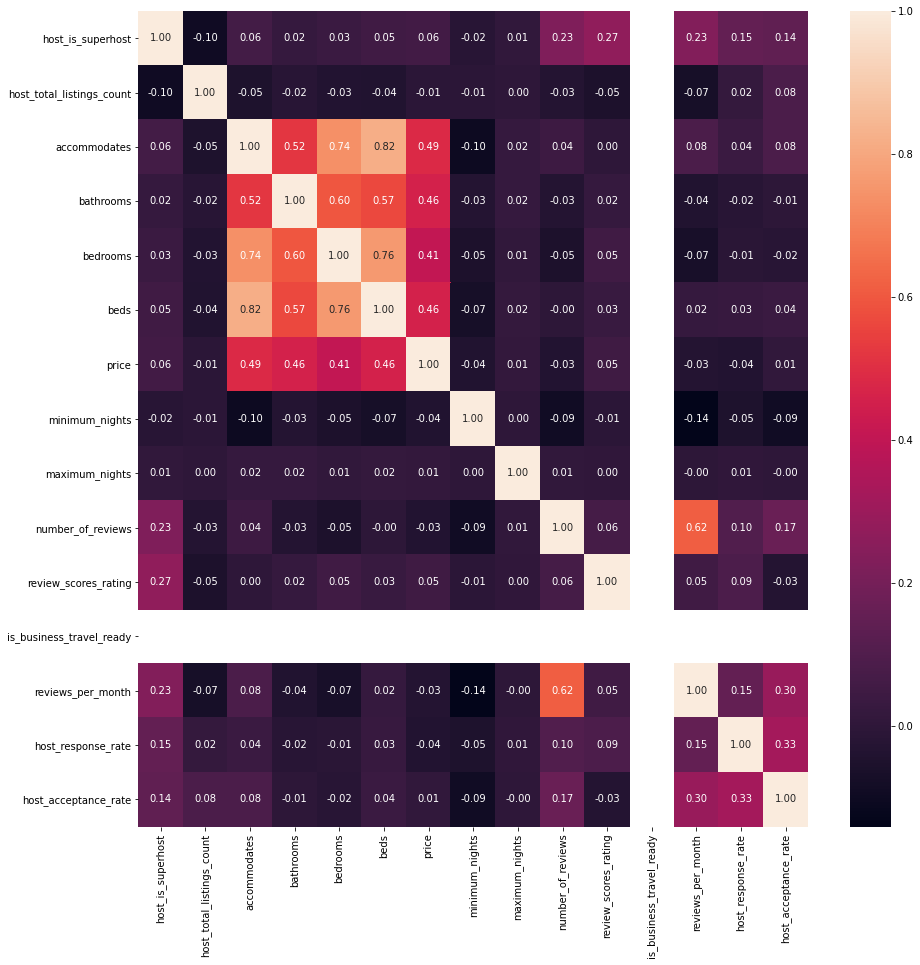

In [62]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df_entire_home.corr(), annot=True, fmt=".2f", ax=ax);

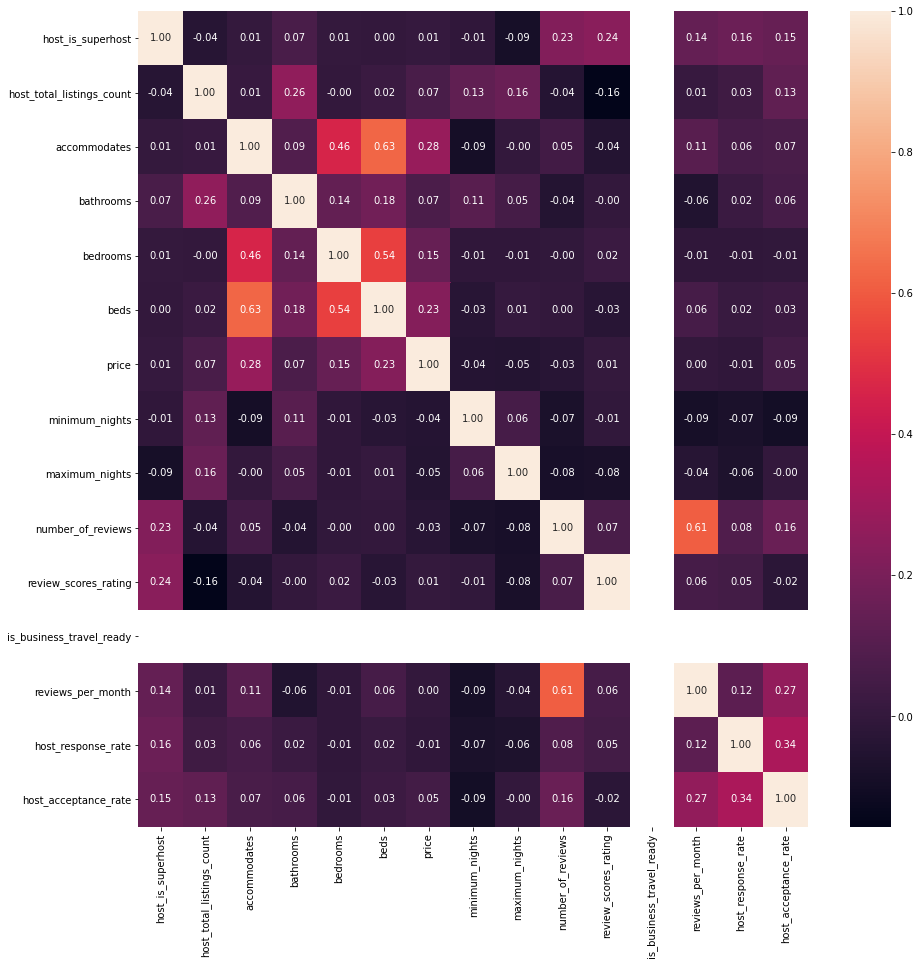

In [69]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(df_private_room.corr(), annot=True, fmt=".2f", ax=ax);

Could be interesting to see that Entire homes (obviously) have sronger correlation to bedrooms,bathrooms and beds as this is intuitively more correlated to area. 

Finally lets look at a description of the  price for each

In [75]:
df_private_room['price'].describe()

count    3423.000000
mean       57.016068
std        77.279866
min        13.000000
25%        31.000000
50%        42.000000
75%        61.000000
max      1500.000000
Name: price, dtype: float64

In [76]:
df_entire_home['price'].describe()

count    10368.000000
mean       137.788870
std        178.937344
min         10.000000
25%         71.000000
50%         99.000000
75%        149.000000
max       4199.000000
Name: price, dtype: float64

The following points are to be considered when making a predictive model given the Montéal dataset: 
* There is not enough data points to start with to generate a meaningful model(around 13K after cleaning).
* The data points distribution is already skewed since more than 50% of them are in 2 main neighbourhoods and 70% of the room types are Entire home/apartment. 
* Location in that sense is a weak indicator since most of the data is concentrated in few central neighbourhoods(skewness of the distribution).
* The remaining strong candidates is area; this is intuitively related to accupancy which in turn is related to number of beds, bathrooms and how much the listing accomodates.